In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, simulate_choice
from scipy.stats import lognorm

<h2> NLM with two nests : measured (1,2) and flat (3,4,5) </h2>

In [2]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]

def log_likelihood_telephone(beta, data):
    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1'] 
    data['U_2'] = beta[4] * data['logcost2'] 
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']
    
    # Calculate logsum for nests with > 1 alt
    data['logsum_measured'] = np.log(data['avail1'] * np.exp(data['U_1'] / beta[5])
                                        + data['avail2'] * np.exp(data['U_2'] / beta[5])
                                        + (1 - data['avail1']) * (1 - data['avail2']))
    data['logsum_flat'] = np.log(data['avail3'] * np.exp(data['U_3'] / beta[6])
                                    + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                    + data['avail5'] * np.exp(data['U_5'] / beta[6])
                                    + (1 - data['avail3']) * (1 - data['avail4']) * (1 - data['avail5']))
    
    # Nest probabilities
    data['P_nest_measured'] = np.exp(beta[5] * data['logsum_measured']) / \
                                 (np.exp(beta[5] * data['logsum_measured']) 
                                  + np.exp(beta[6] * data['logsum_flat']))
    data['P_nest_flat'] = 1 - data['P_nest_measured']
    
    # Within nest probabilities for nests with > 1 alt
    data['P_1_in_measured'] = data['avail1'] * np.exp(data['U_1'] / beta[5]) / \
                                (data['avail1'] * np.exp(data['U_1'] / beta[5]) 
                                 + data['avail2'] * np.exp(data['U_2'] / beta[5]))
    data['P_2_in_measured'] = 1 - data['P_1_in_measured']

    data['P_3_in_flat'] = data['avail3'] * np.exp(data['U_3'] / beta[6]) / \
                            (data['avail3'] * np.exp(data['U_3'] / beta[6])
                                + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                + data['avail5'] * np.exp(data['U_5'] / beta[6]))
    data['P_4_in_flat'] = data['avail4'] * np.exp(data['U_4'] / beta[6]) / \
                            (data['avail3'] * np.exp(data['U_3'] / beta[6])
                                + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                + data['avail5'] * np.exp(data['U_5'] / beta[6]))
    data['P_5_in_flat'] = 1 - data['P_3_in_flat'] - data['P_4_in_flat']
    
    # Full probabilities
    data['P_1'] = data['P_nest_measured'] * data['P_1_in_measured']
    data['P_2'] = data['P_nest_measured'] * data['P_2_in_measured']
    data['P_3'] = data['P_nest_flat'] * data['P_3_in_flat']
    data['P_4'] = data['P_nest_flat'] * data['P_4_in_flat']
    data['P_5'] = data['P_nest_flat'] * data['P_5_in_flat']
    
    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data.loc[data['P'] == 0, 'P'] = epsilon
    
    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [3]:
# Load data
data = pd.read_csv('./data/telephone.dat', sep='\t')

data['logcost1'] = np.log(data['cost1'])
data['logcost2'] = np.log(data['cost2'])
data['logcost3'] = np.log(data['cost3'])
data['logcost4'] = np.log(data['cost4'])
data['logcost5'] = np.log(data['cost5'])

# Define model parameters
beta = np.array([0, 0, 0, 0, 0, 1, 1])
# lambda_n = 1 / mu_n is a measure of the degree of independence in unobserved utility among
# the alternatives in nest n.
# It should be between 0 and 1 with lambda_n = 1 indicating full independence.
beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]


In [4]:
# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data, beta, beta_names, log_likelihood_telephone)

Optimization Results:
         Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0            ASC_1 -0.378246              0.125454    -3.015006  2.723024e-03
1            ASC_3  0.893446              0.171565     5.207627  2.980374e-07
2            ASC_4  0.847293              0.393757     2.151815  3.197195e-02
3            ASC_5  1.405502              0.259374     5.418828  1.004633e-07
4        BETA_COST -1.490024              0.252883    -5.892149  7.739943e-09
5  lambda_measured  0.484798              0.139705     3.470160  5.730726e-04
6      lambda_flat  0.436216              0.121307     3.595981  3.609402e-04
AIC: 960.4386663193137
BIC: 988.9499780580165


---
---
---
---
---

<h2> Applying DIB algorithm </h2>

<h2> Modified version of the DIB algorithm where the maximum number of clusters is the number of alternatives, not the number of individuals </h2>

In [5]:
from functions_geom_DIB import geom_DIB_on_alternatives

<h3> We try to apply IB/DIB to p(x,y) = p(y|x)p(x) where 

- p(y|x) comes from the P_i
- p(x) comes from a chosen distribution
</h3>

<h2> We take logcost as a lognormal random variable and we assume independence between the costs </h2>

<h2> Lognormal distribution for each cost on raw data </h2>

In [6]:
# Function to compute the probability density function (PDF) of a univariate lognormal distribution
def lognormal_pdf(x, mu, sigma):
    """
    Compute the probability density function (PDF) of a univariate lognormal distribution.

    Parameters:
        x (float or ndarray): Value or array of values for which to compute the PDF.
        mu (float): Mean of ln(X).
        sigma (float): Standard deviation of ln(X).

    Returns:
        float or ndarray: Value of the PDF at x.
    """
    pdf = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
    return pdf

In [7]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]

mu = np.log(df_logcost).mean()
sigma = np.log(df_logcost).std()

# Compute PDF for each log-transformed cost and create new columns for each
for col in df_logcost.columns:
    df_logcost[f'{col}_pdf'] = lognormal_pdf(df_logcost[col], mu[col], sigma[col])

# Compute the joint probability density function (PDF) of the log-transformed costs
df_logcost['probability'] = df_logcost['logcost1_pdf'] * df_logcost['logcost2_pdf'] * \
    df_logcost['logcost3_pdf'] * df_logcost['logcost4_pdf'] * df_logcost['logcost5_pdf']

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13569/112596394.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost[f'{col}_pdf'] = lognormal_pdf(df_logcost[col], mu[col], sigma[col])
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13569/112596394.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost[f'{col}_pdf'] = lognormal_pdf(df_logcost[col], mu[col], sigma[col])
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13569/112596394.py:8: SettingWithCopyWarn

In [8]:
# Computation of p(x,y)
p_x = df_logcost['probability'].values
p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

In [9]:
np.random.seed(123)
data['simulated_choice'] = data.apply(simulate_choice, axis=1)

In [10]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=30, max_iter=5000, threshold=1e-5)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

In [11]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 4

 cluster
3    185
1    125
2    114
0     10
Name: count, dtype: int64

 choice    1   2   3  4   5
cluster                   
0         2   1   3  3   1
1        19  55  50  0   1
2        35  25  51  0   3
3        17  42  74  0  52

 max_proba   1   2    3  4   5
cluster                      
0           0   0    7  2   1
1           0   0  125  0   0
2          48   2   64  0   0
3           0  83   60  0  42

 simulated_choice   1   2   3  4   5
cluster                            
0                  2   2   3  2   1
1                 12  41  72  0   0
2                 38  33  41  0   2
3                 23  52  57  0  53


Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

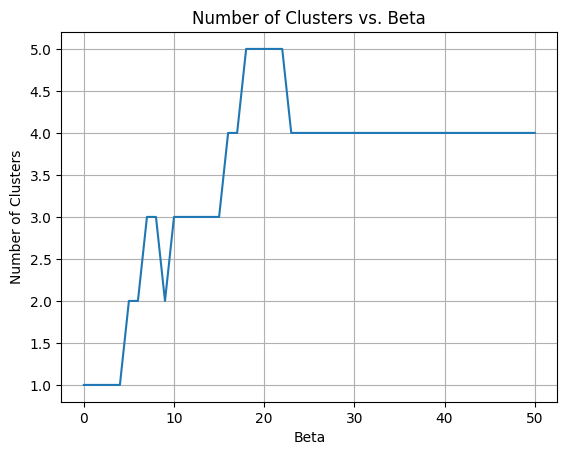

In [12]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

---
---
---
---
---

<h2> lognormal distribution for each cost without missing data </h2>

In [31]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3']]

mu = np.log(df_logcost).mean()
sigma = np.log(df_logcost).std()

# Compute PDF for each log-transformed cost and create new columns for each
for col in df_logcost.columns:
    df_logcost[f'{col}_pdf'] = lognormal_pdf(df_logcost[col], mu[col], sigma[col])

# Remove rows with cost4 = 100000 to compute mean and covariance
df_logcost['true_logcost4'] = data['logcost4'] * data['avail4']
df_logcost['true_logcost4'] = df_logcost['true_logcost4'].replace(0, np.nan)
mu4 = np.log(df_logcost['true_logcost4']).mean()
sigma4 = np.log(df_logcost['true_logcost4']).std()
df_logcost['logcost4'] = data['logcost4']
df_logcost['logcost4_pdf'] = lognormal_pdf(df_logcost['logcost4'], mu4, sigma4)

# Remove rows with cost5 = 100000 to compute mean and covariance
df_logcost['true_logcost5'] = data['logcost5'] * data['avail5']
df_logcost['true_logcost5'] = df_logcost['true_logcost5'].replace(0, np.nan)
mu5 = np.log(df_logcost['true_logcost5']).mean()
sigma5 = np.log(df_logcost['true_logcost5']).std()
df_logcost['logcost5'] = data['logcost5']
df_logcost['logcost5_pdf'] = lognormal_pdf(df_logcost['logcost5'], mu5, sigma5)

# Compute the joint probability density function (PDF) of the log-transformed costs
df_logcost['probability'] = df_logcost['logcost1_pdf'] * df_logcost['logcost2_pdf'] * \
    df_logcost['logcost3_pdf'] * df_logcost['logcost4_pdf'] * df_logcost['logcost5_pdf']

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13569/1922668401.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost[f'{col}_pdf'] = lognormal_pdf(df_logcost[col], mu[col], sigma[col])
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13569/1922668401.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost[f'{col}_pdf'] = lognormal_pdf(df_logcost[col], mu[col], sigma[col])
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13569/1922668401.py:8: SettingWithCopyW

In [32]:
# Computation of p(x,y)
p_x = df_logcost['probability'].values
p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

In [33]:
np.random.seed(123)
data['simulated_choice'] = data.apply(simulate_choice, axis=1)

In [34]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=22, max_iter=5000, threshold=1e-5)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

In [35]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 4

 cluster
3    156
0    133
2    111
1     34
Name: count, dtype: int64

 choice    1   2   3  4   5
cluster                   
0        14  37  58  0  24
1         1   1   4  0  28
2        24  22  58  2   5
3        34  63  58  1   0

 max_proba   1   2    3  4   5
cluster                      
0           0  78   46  0   9
1           0   0    0  0  34
2          44   7   60  0   0
3           4   0  150  2   0

 simulated_choice   1   2   3  4   5
cluster                            
0                 21  44  46  0  22
1                  0   2   2  0  30
2                 34  33  39  1   4
3                 20  49  86  1   0


Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

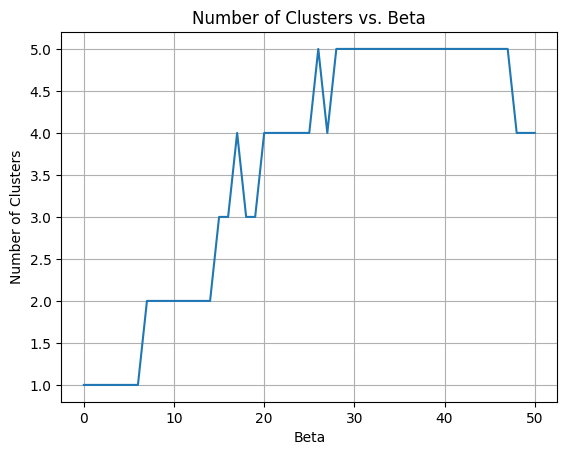

In [18]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

---
---
---
---
---

<h2> Lognormal distribution for cost1,2,3,4 empirical distribution for cost 5, nested logit model </h2>

In [19]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4']]

mu = np.log(df_logcost).mean()
sigma = np.log(df_logcost).std()

# Compute PDF for each log-transformed cost and create new columns for each
for col in df_logcost.columns:
    df_logcost[f'{col}_pdf'] = lognormal_pdf(df_logcost[col], mu[col], sigma[col])

# Compute empirical probabilities for logcost5
empirical_probs = data['logcost5'].value_counts(normalize=True)

# Assign empirical probabilities to a new column based on values in column 'x'
df_logcost['logcost5_pdf'] = data['logcost5'].map(empirical_probs)

# Compute the joint probability density function (PDF) of the log-transformed costs
df_logcost['probability'] = df_logcost['logcost1_pdf'] * df_logcost['logcost2_pdf'] * \
    df_logcost['logcost3_pdf'] * df_logcost['logcost4_pdf'] * df_logcost['logcost5_pdf']

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13569/2418499511.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost[f'{col}_pdf'] = lognormal_pdf(df_logcost[col], mu[col], sigma[col])
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13569/2418499511.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost[f'{col}_pdf'] = lognormal_pdf(df_logcost[col], mu[col], sigma[col])
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13569/2418499511.py:8: SettingWithCopyW

In [20]:
# Computation of p(x,y)
p_x = df_logcost['probability'].values
p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

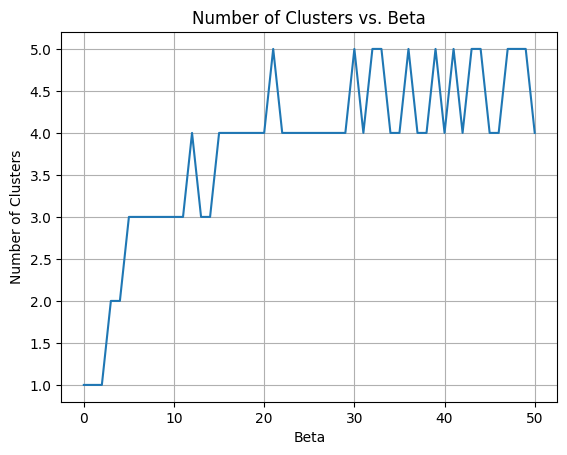

In [21]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [22]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=25, max_iter=5000, threshold=1e-5)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000


In [23]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 4

 cluster
4    146
3    134
0    107
1     47
Name: count, dtype: int64

 choice    1   2   3  4   5
cluster                   
0        34  20  50  0   3
1         3   2   7  3  32
3        21  60  52  0   1
4        15  41  69  0  21

 max_proba   1   2    3  4   5
cluster                      
0          48   3   56  0   0
1           0   0    8  2  37
3           0   0  134  0   0
4           0  82   58  0   6

 simulated_choice   1   2   3  4   5
cluster                            
0                 39  28  37  0   3
1                  3   6   6  2  30
3                 12  46  76  0   0
4                 21  48  54  0  23


---
---
---
---
---

<h2> Lognormal distribution for cost1,2,3 empirical distribution for cost 4,5, nested logit model </h2>

In [24]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3']]

mu = np.log(df_logcost).mean()
sigma = np.log(df_logcost).std()

# Compute PDF for each log-transformed cost and create new columns for each
for col in df_logcost.columns:
    df_logcost[f'{col}_pdf'] = lognormal_pdf(df_logcost[col], mu[col], sigma[col])

# Compute empirical probabilities for logcost5
empirical_probs = data['logcost4'].value_counts(normalize=True)
# Assign empirical probabilities to a new column based on values in column 'x'
df_logcost['logcost4_pdf'] = data['logcost4'].map(empirical_probs)

# Compute empirical probabilities for logcost5
empirical_probs = data['logcost5'].value_counts(normalize=True)
# Assign empirical probabilities to a new column based on values in column 'x'
df_logcost['logcost5_pdf'] = data['logcost5'].map(empirical_probs)

# Compute the joint probability density function (PDF) of the log-transformed costs
df_logcost['probability'] = df_logcost['logcost1_pdf'] * df_logcost['logcost2_pdf'] * \
    df_logcost['logcost3_pdf'] * df_logcost['logcost4_pdf'] * df_logcost['logcost5_pdf']

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13569/2082815957.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost[f'{col}_pdf'] = lognormal_pdf(df_logcost[col], mu[col], sigma[col])
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13569/2082815957.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logcost[f'{col}_pdf'] = lognormal_pdf(df_logcost[col], mu[col], sigma[col])
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_13569/2082815957.py:8: SettingWithCopyW

In [25]:
# Computation of p(x,y)
p_x = df_logcost['probability'].values
p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

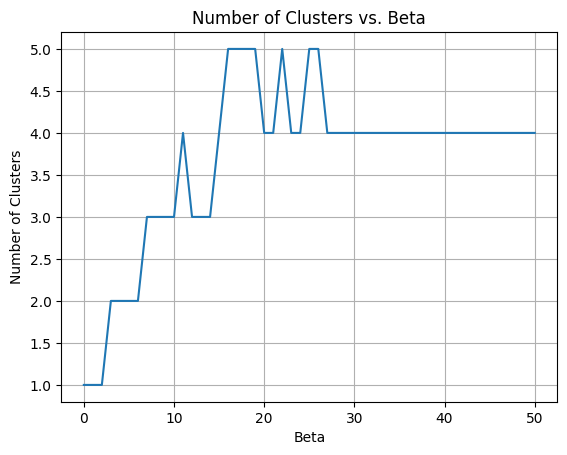

In [26]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [27]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=40, max_iter=5000, threshold=1e-5)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000


In [28]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 4

 cluster
4    183
3    134
0    107
1     10
Name: count, dtype: int64

 choice    1   2   3  4   5
cluster                   
0        34  20  50  0   3
1         2   1   3  3   1
3        21  60  52  0   1
4        16  42  73  0  52

 max_proba   1   2    3  4   5
cluster                      
0          48   3   56  0   0
1           0   0    7  2   1
3           0   0  134  0   0
4           0  82   59  0  42

 simulated_choice   1   2   3  4   5
cluster                            
0                 39  28  37  0   3
1                  2   2   3  2   1
3                 12  46  76  0   0
4                 22  52  57  0  52
